In [ ]:
### topic --> Linkedin post generate ----> HITL ----> Post it using API

## HITL - LangGraph actually interrupt after  Linkedin post generate and before HITL. So we can check the state of workflow and resume it after that. 
# This is similar to checkpointing and resuming a workflow. So we also need to do persistence again.

In [ ]:
## Timetravel - We can replay the workflow from the beginning or at any stage and check the state at each step. 
# This is similar to debugging a code and checking the state at each step. So we also need to do persistence again.

## Lets try to implement this in the next few cells.

## TimeTravel

In [37]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
import operator
from dotenv import load_dotenv
import os
from euriai.langchain import create_chat_model
from langgraph.checkpoint.memory import InMemorySaver
import time

load_dotenv()
api_key = os.getenv("key")

chat_model = create_chat_model(
    api_key=api_key,
    model="gpt-4.1-nano",
    temperature=0.7
)

In [38]:
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

In [39]:
def generate_joke(state: JokeState):
    topic = state['topic']
    joke_prompt = f"Tell me a joke about {topic}."
    joke_response = chat_model.invoke(joke_prompt).content
    
    return {"joke": joke_response}

def explain_joke(state: JokeState):
    joke = state['joke']
    explanation_prompt = f"Explain the following joke: {joke}"
    explanation_response = chat_model.invoke(explanation_prompt).content
    
    return {"explanation": explanation_response}

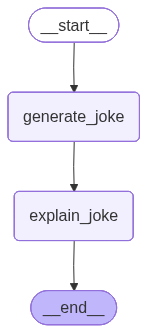

In [40]:
graph = StateGraph(JokeState)

graph.add_node("generate_joke", generate_joke)
graph.add_node("explain_joke", explain_joke)

graph.add_edge(START, "generate_joke")
graph.add_edge("generate_joke", "explain_joke")
graph.add_edge("explain_joke", END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [41]:
## This will start a new thread with thread_id "1" and run the workflow with the given input

config1 = {"configurable": {"thread_id": "1"}}

final_state = workflow.invoke({"topic": "AI"}, config=config1)
final_state

{'topic': 'AI',
 'joke': "Sure! Here's a joke about AI:\n\nWhy did the AI go to therapy?  \nBecause it had too many processing issues!",
 'explanation': 'Certainly! This joke plays on the idea of "processing issues," which is a common term in psychology referring to mental or emotional difficulties. In the context of AI, "processing" relates to how the computer processes data. The humor comes from blending these two meanings: suggesting that the AI has emotional or mental struggles (like a person might have in therapy) because it has "processing issues." It\'s a pun that combines psychological language with computer terminology to create a funny, light-hearted joke about AI experiencing human-like problems.'}

In [42]:
type(final_state)

dict

In [43]:
workflow.get_state(config={"configurable": {"thread_id": "1"}})

StateSnapshot(values={'topic': 'AI', 'joke': "Sure! Here's a joke about AI:\n\nWhy did the AI go to therapy?  \nBecause it had too many processing issues!", 'explanation': 'Certainly! This joke plays on the idea of "processing issues," which is a common term in psychology referring to mental or emotional difficulties. In the context of AI, "processing" relates to how the computer processes data. The humor comes from blending these two meanings: suggesting that the AI has emotional or mental struggles (like a person might have in therapy) because it has "processing issues." It\'s a pun that combines psychological language with computer terminology to create a funny, light-hearted joke about AI experiencing human-like problems.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe79-7dd5-6d2f-8002-ac2ac575073a'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-02-22T12:11:18.492482+00:00', parent_config={'configurabl

In [44]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'AI', 'joke': "Sure! Here's a joke about AI:\n\nWhy did the AI go to therapy?  \nBecause it had too many processing issues!", 'explanation': 'Certainly! This joke plays on the idea of "processing issues," which is a common term in psychology referring to mental or emotional difficulties. In the context of AI, "processing" relates to how the computer processes data. The humor comes from blending these two meanings: suggesting that the AI has emotional or mental struggles (like a person might have in therapy) because it has "processing issues." It\'s a pun that combines psychological language with computer terminology to create a funny, light-hearted joke about AI experiencing human-like problems.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe79-7dd5-6d2f-8002-ac2ac575073a'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-02-22T12:11:18.492482+00:00', parent_config={'configurab

In [46]:
checkpoint_id1 = "1f10fe79-5e90-623b-8000-a609d3f763e9"
workflow.get_state(config={"configurable": {"thread_id": "1", "checkpoint_id": checkpoint_id1}})

StateSnapshot(values={'topic': 'AI'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f10fe79-5e90-623b-8000-a609d3f763e9'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-22T12:11:15.213355+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe79-5e8d-6bd7-bfff-abb4b06ed614'}}, tasks=(PregelTask(id='08c33441-d4af-e506-552b-1b661374b69e', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': "Sure! Here's a joke about AI:\n\nWhy did the AI go to therapy?  \nBecause it had too many processing issues!"}),), interrupts=())

In [47]:
workflow.invoke(None, config={"configurable": {"thread_id": "1", "checkpoint_id": checkpoint_id1}})

{'topic': 'AI',
 'joke': "Sure! Here's a joke about AI:\n\nWhy did the AI go to therapy?\n\nBecause it had too many layers of emotional baggage!",
 'explanation': 'Sure! The joke plays on two ideas: the technical structure of artificial intelligence and the concept of emotional baggage.\n\nIn AI, "layers" refer to the layers of a neural network, which are the fundamental building blocks that process information. The more layers an AI has, the more complex its processing.\n\nOn the other hand, "emotional baggage" is a common phrase meaning unresolved emotional issues from the past that can affect a person\'s mental health.\n\nThe humor comes from combining these ideas: suggesting that the AI has "layers" in its neural network (a technical term) and "emotional baggage" (a human emotional concept). The joke implies that the AI is going to therapy because it has "too many layers of emotional baggage," blending technical jargon with a human psychological issue in a funny way.'}

In [48]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'AI', 'joke': "Sure! Here's a joke about AI:\n\nWhy did the AI go to therapy?\n\nBecause it had too many layers of emotional baggage!", 'explanation': 'Sure! The joke plays on two ideas: the technical structure of artificial intelligence and the concept of emotional baggage.\n\nIn AI, "layers" refer to the layers of a neural network, which are the fundamental building blocks that process information. The more layers an AI has, the more complex its processing.\n\nOn the other hand, "emotional baggage" is a common phrase meaning unresolved emotional issues from the past that can affect a person\'s mental health.\n\nThe humor comes from combining these ideas: suggesting that the AI has "layers" in its neural network (a technical term) and "emotional baggage" (a human emotional concept). The joke implies that the AI is going to therapy because it has "too many layers of emotional baggage," blending technical jargon with a human psychological issue in a funny

In [49]:
workflow.update_state(config={"configurable": {"thread_id": "1", "checkpoint_id": checkpoint_id1, "checkpoint_ns": ""}}, values={"topic": "pizza"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10fe7b-20ea-63a9-8001-6fb53ed597dc'}}

In [50]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'pizza'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe7b-20ea-63a9-8001-6fb53ed597dc'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2026-02-22T12:12:02.436171+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe79-5e90-623b-8000-a609d3f763e9'}}, tasks=(PregelTask(id='c98184bc-45c8-fb1c-244d-14ecefa93a6c', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'AI', 'joke': "Sure! Here's a joke about AI:\n\nWhy did the AI go to therapy?\n\nBecause it had too many layers of emotional baggage!", 'explanation': 'Sure! The joke plays on two ideas: the technical structure of artificial intelligence and the concept of emotional baggage.\n\nIn AI, "layers" refer to the layers of a neural network, which are the

In [51]:
workflow.invoke(None, config={"configurable": {"thread_id": "1", "checkpoint_id": "1f10fe7b-20ea-63a9-8001-6fb53ed597dc"}})

{'topic': 'pizza',
 'joke': "Sure! Here's a pizza joke for you:\n\nWhy did the pizza go to the party?\n\nBecause it was topping the charts!",
 'explanation': 'Certainly! This joke is a play on words involving pizza toppings and the phrase "topping the charts." \n\n- "Topping the charts" is an idiom meaning to be very popular or at the top of a ranking, often used in music or entertainment contexts.\n- In the joke, the pizza "went to the party" because it was "topping the charts," humorously suggesting that the pizza was both literally topped with ingredients (like cheese and toppings) and figuratively at the top of popularity.\n\nThe humor arises from the double meaning: the pizza\'s toppings and its popularity are linked in a pun.'}

In [52]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Sure! Here's a pizza joke for you:\n\nWhy did the pizza go to the party?\n\nBecause it was topping the charts!", 'explanation': 'Certainly! This joke is a play on words involving pizza toppings and the phrase "topping the charts." \n\n- "Topping the charts" is an idiom meaning to be very popular or at the top of a ranking, often used in music or entertainment contexts.\n- In the joke, the pizza "went to the party" because it was "topping the charts," humorously suggesting that the pizza was both literally topped with ingredients (like cheese and toppings) and figuratively at the top of popularity.\n\nThe humor arises from the double meaning: the pizza\'s toppings and its popularity are linked in a pun.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10fe7b-f4d0-65d6-8003-6727c9b3ee6b'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-02-22T12:12:24.655392+00:00', p